# Training Models
Whenever we are in the presence of a classification problem, the first thing to do is to identify the target or class, which is the variable to predict. The type of the target variable determines the kind of operation to perform: targets with just a few values allow for a classification task, while real-valued targets require a prediction one.

## Heart Failure Prediction Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import train_test_split

data: pd.DataFrame = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')
target = 'DEATH_EVENT'
positive = 1
negative = 0
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)

In [2]:
X.shape
values

{'Original': [96, 203]}

After loading the data, in data dataframe, we need to separate the target variable from the rest of the data, since it plays a different role in the training procedure. Through the application of the pop method, we get the class variable, and simultaneously removing it from the dataframe. So, y will keep the ndarray with the target variable for each record and X the ndarray containing the records themselves.

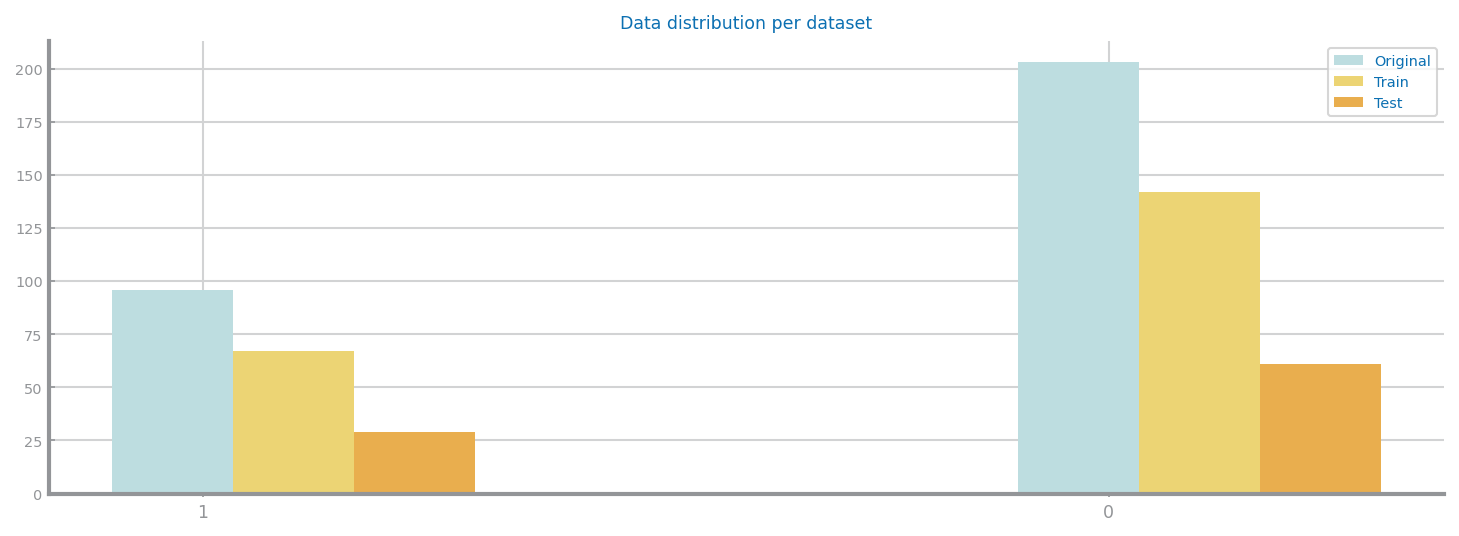

In [3]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

We can clearly see a major unbalance between positive and negative target variables.

### Evaluating a Model
The evaluation of the results of each learnt model, in the classification paradigm, is objective and straightforward. We just need to assess if the predicted labels are correct, which is done by measuring the number of records where the predicted label is equal to the known ones.

#### Accuracy
One of the easiest, most direct ways to measure the performance of a given model consists of calculating the number of hits / number of misses: the accuracy.

In [4]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(trnX, trnY)
clf.score(tstX, tstY)

0.7888888888888889

Gaussian Naïve Bayes doesn't work all that well, with a little over 75% accuracy. But the accuracy alone does not tell us where the errors are ocurring or where the model is failing. For that, we need to look into the Confusion Matrix.

#### Confusion Matrix
Indeed, first we need to distinguish among the errors. In the presence of binary classification problems (there are only two possible outcomes for the target variable), this distinction is easy. Usually, we call negative to the most common target value and positive to the other one.

From this, we have:

* true positives (TP): the number of positive records rightly predicted as positve;

* true negatives (TN): the number of negatives records rightly predicted as negative;

* false positives (FP): the number of negative records wrongly predicted as positve;

* false negatives (FN): the number of positive records wrongly predicted as negative;

The confusion matrix is the standard to present these numbers, and is computed through the confusion matrix in the sklearn.metrics package.

In [5]:
import numpy as np
import sklearn.metrics as metrics

labels: np.ndarray = pd.unique(y)
prdY: np.ndarray = clf.predict(tstX)
cnf_mtx: np.ndarray = metrics.confusion_matrix(tstY, prdY, labels)
cnf_mtx

array([[16, 13],
       [ 6, 55]], dtype=int64)

Plotting it:

<Figure size 600x450 with 0 Axes>

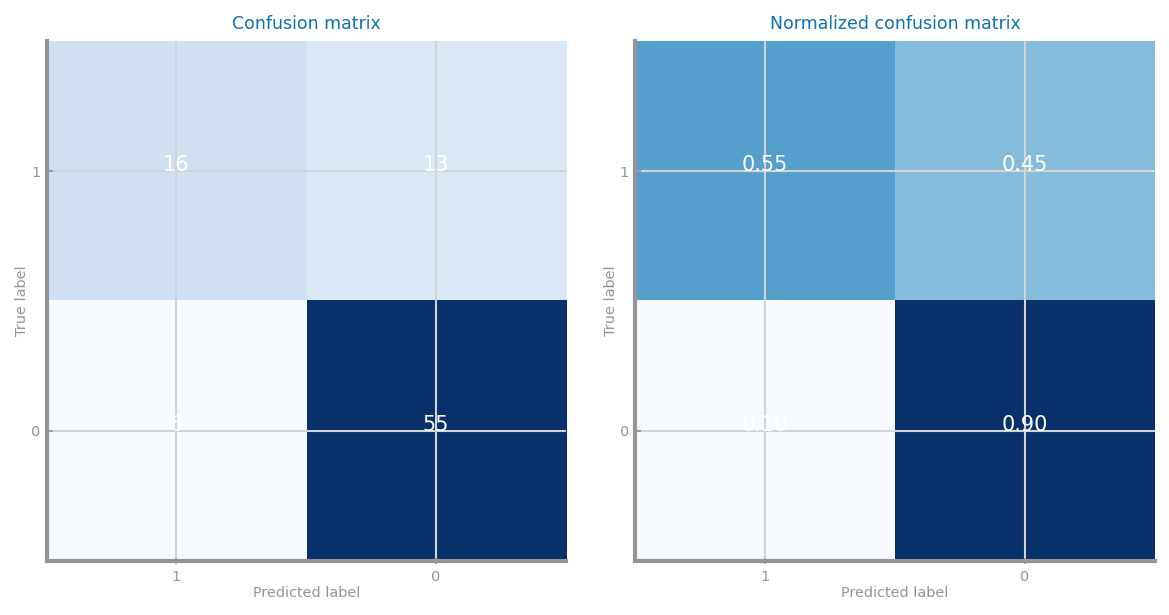

In [6]:
import itertools
import matplotlib.pyplot as plt
CMAP = plt.cm.Blues

def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray, ax: plt.Axes = None,
                          normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=CMAP)

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='w', horizontalalignment="center")

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(cnf_mtx, labels, ax=axs[0,0])
plot_confusion_matrix(metrics.confusion_matrix(tstY, prdY, labels), labels, axs[0,1], normalize=True)
plt.tight_layout()
plt.show()

We can also easily obtain useful metrics using this sklearn.metrics

In [7]:
recall = metrics.recall_score(tstY, prdY) # reveals the models ability to recognize the positive records
precision = metrics.precision_score(tstY, prdY) # reveals the models ability to not misclassify negative records
f1 = metrics.f1_score(tstY, prdY) # computes the average between precision and recall
balanced_acc = metrics.balanced_accuracy_score(tstY, prdY) # reveals the average of recall scores for all the classes

print(f"Recall Score: {recall}")
print(f"Precision Score: {precision}")
print(f"F1 Score: {f1}")
print(f"Balanced Accuracy Score: {balanced_acc}")

Recall Score: 0.5517241379310345
Precision Score: 0.7272727272727273
F1 Score: 0.6274509803921569
Balanced Accuracy Score: 0.7266817410966648


#### ROC Charts
ROC charts are another mean to understand models' performance, in particular in the presence of binary non balanced datasets. They present the balance between True Positive rate (recall) and False Positive rate in a graphical way, and are available through the roc_curve method in the sklearn.metrics

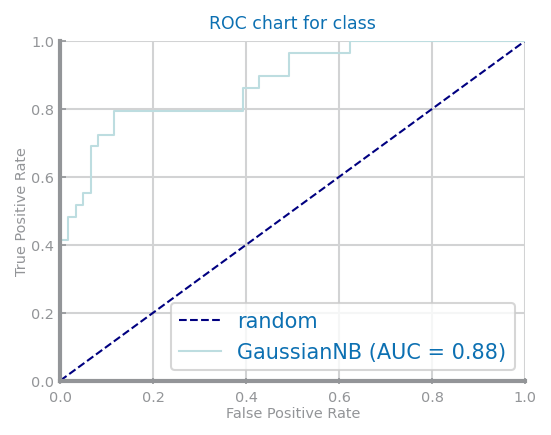

In [8]:
def plot_roc_chart(models: dict, tstX: np.ndarray, tstY: np.ndarray, ax: plt.Axes = None, target: str = 'class'):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s' % target)

    ax.plot([0, 1], [0, 1], color='navy', label='random', linewidth=1, linestyle='--',  marker='')
    for clf in models.keys():
        metrics.plot_roc_curve(models[clf], tstX, tstY, ax=ax, marker='', linewidth=1)
    ax.legend(loc="lower right")


data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')
y = data.pop('DEATH_EVENT').values
X = data.values
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
model = GaussianNB().fit(trnX, trnY)

plt.figure()
plot_roc_chart({'GaussianNB': model}, tstX, tstY, target='class')
plt.show()

The area under the roc curve, auc for short, is another important measure, mostly for unbalanced datasets. It is available as roc_auc_score, in the sklearn.metric package, and receives the known labels in its first parameter and the previous computed scores as the second one, just like roc_curve method.

## Oral Toxicity Dataset

In [9]:
data: pd.DataFrame = pd.read_csv('../datasets/qsar_oral_toxicity.csv', sep=';', header=None)

In [10]:
positive = 'positive'
negative = 'negative'
values = {'Original': [len(data.loc[(data.iloc[:,-1:] == positive).values]), len(data.loc[(data.iloc[:,-1:] == negative).values])]}

y: np.ndarray = data.iloc[:,-1:].values
y: np.ndarray = np.array([x[0] for x in y])

X: np.ndarray = data.iloc[:,:-1]
labels: np.ndarray = pd.unique(y)


After loading the data, in data dataframe, we need to separate the target variable from the rest of the data, since it plays a different role in the training procedure. Through the application of the pop method, we get the class variable, and simultaneously removing it from the dataframe. So, y will keep the ndarray with the target variable for each record and X the ndarray containing the records themselves.

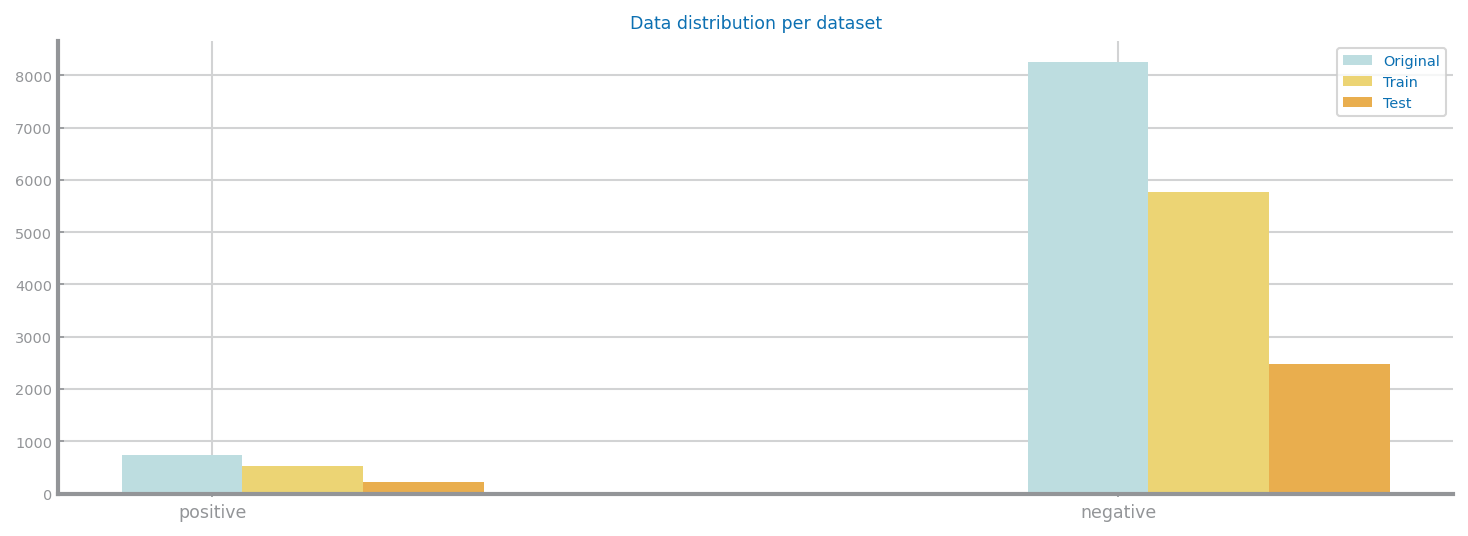

In [11]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per dataset')
plt.show()

This dataset is even less balanced than the last one, with much more negative samples rather than positive.

## Evaluating a Model
The evaluation of the results of each learnt model, in the classification paradigm, is objective and straightforward. We just need to assess if the predicted labels are correct, which is done by measuring the number of records where the predicted label is equal to the known ones.

#### Accuracy
One of the easiest, most direct ways to measure the performance of a given model consists of calculating the number of hits / number of misses: the accuracy.

In [12]:
clf = GaussianNB()

clf.fit(trnX, trnY)
clf.score(tstX, tstY)

0.7720533728687917

Much like the previous example, the Gaussian Naïve Bayes model does not perform very well, with an accuracy of roughly 75%. Let us analyze where the model is failing by looking at the confusion matrix.

#### Confusion Matrix

In [13]:
labels: np.ndarray = pd.unique(y)
prdY: np.ndarray = clf.predict(tstX)
cnf_mtx: np.ndarray = metrics.confusion_matrix(tstY, prdY, labels)
cnf_mtx

array([[1926,  550],
       [  65,  157]], dtype=int64)

<Figure size 600x450 with 0 Axes>

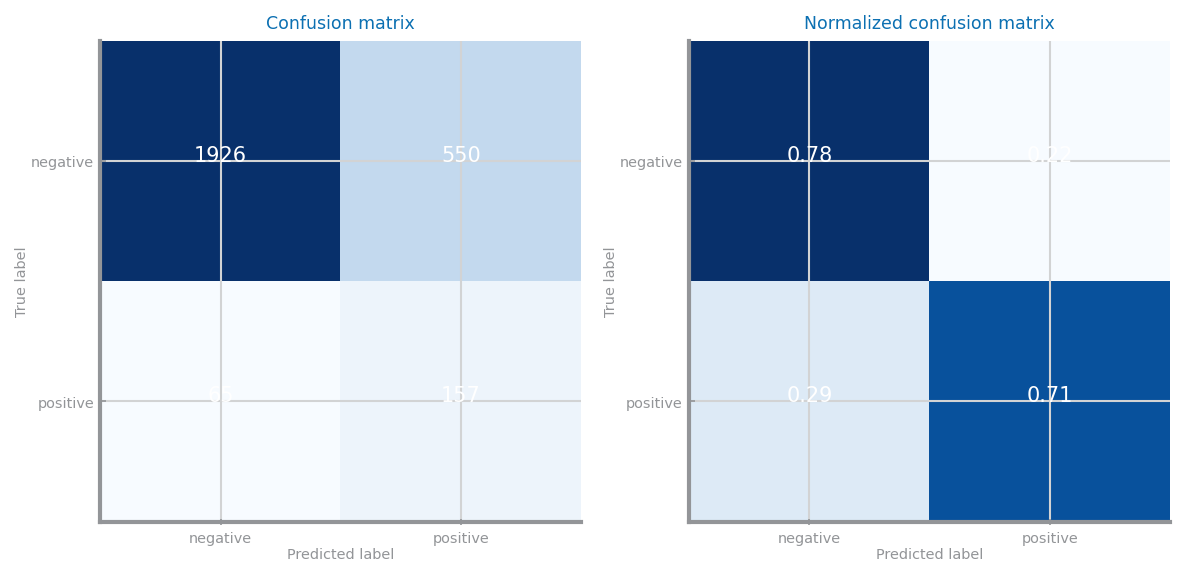

In [14]:
plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(cnf_mtx, labels, ax=axs[0,0])
plot_confusion_matrix(metrics.confusion_matrix(tstY, prdY, labels), labels, axs[0,1], normalize=True)
plt.tight_layout()
plt.show()

#### ROC Charts
ROC charts are another mean to understand models' performance, in particular in the presence of binary non balanced datasets. They present the balance between True Positive rate (recall) and False Positive rate in a graphical way, and are available through the roc_curve method in the sklearn.metrics

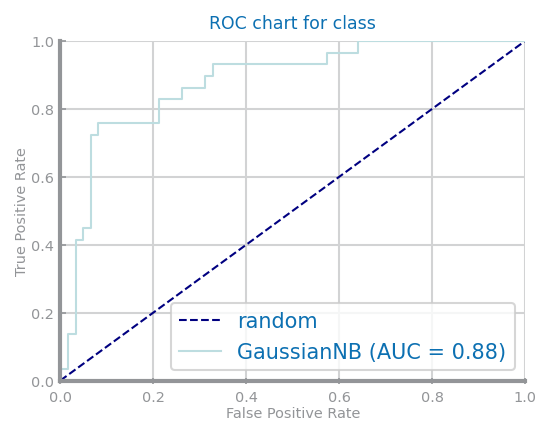

In [15]:
data = pd.read_csv('../datasets/heart_failure_clinical_records_dataset.csv')
y = data.pop('DEATH_EVENT').values
X = data.values
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
model = GaussianNB().fit(trnX, trnY)

plt.figure()
plot_roc_chart({'GaussianNB': model}, tstX, tstY, target='class')
plt.show()